In [1]:
%%capture
%cd ..

### Table of Contents

- [Modeling](#Modeling)
- [Plot Feature Importance](#Plot-Feature-Importance)
- [Plot Partial Dependence](#Plot-Partial-Dependence)
- [Plot Threshold Dependent Metrics](#Plot-Threshold-Dependent-Metrics)
- [Test and Attach Models](#Test-and-Attach-Models)

---

### Import Libraries and Data

In [2]:
from examples.make_sample_data import make_forest_cover_data
from OrderedOVRClassifier import OrderedOVRClassifier

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

For this tutorial, we will be using the [Covertype dataset](http://archive.ics.uci.edu/ml/datasets/Covertype).

**Dataset Characteristics**  
- Target variable: <font color='green'>Cover_Type</font> *(7 classes)*  
- Attributes: <font color='green'>54</font> *(10 quantitative, 44 binary)*  
- Rows: <font color='green'>581012</font>

In [3]:
train_df, test_df = make_forest_cover_data()

---

### Modeling

This is an example of how to initiate the OrderedOVRClassifier model.  

Let's say we are interested in training seperate binary classifiers for <font color='green'>Cover_Type</font> values 2,6,5. The order of the training is specified with the **ovr_vals** parameter, and the machine learning models to train OrderedOVRClassifier with is defined in the **model_dict**.  

The parameters passed into the init parameters of OrderedOVRClassifier indicates the following instructions:
- **Step 1**. Train class *2* vs classes *(1,3,4,5,6,7)* with a RandomForestClassifier.
- **Step 2**. Train class *6* vs classes *(1,3,4,5,7)* with a DecistionTreeClassifier.
- **Step 3**. Train class *5* vs classes *(1,3,4,7)* with an ExtraTreesClassifier.
- **Step 4**. Train a multiclass model on the remaining classes with a LGBMClassifier and pass verbose=10 to the fit function.

In [4]:
model_dict = {2: RandomForestClassifier(n_estimators=100),
              6: DecisionTreeClassifier(min_samples_split=4, criterion='entropy'),
              5: ExtraTreesClassifier(n_estimators=100),
              'final': LGBMClassifier(n_estimators=100)}

model_fit_params = {'final': {'verbose': 10}}

oovr = OrderedOVRClassifier(target='Cover_Type',
                            ovr_vals=[2, 6, 5],
                            model_dict=model_dict,
                            model_fit_params=model_fit_params)

Since `'Cover_Type'` was defined as the target varaible when initializing OrderedOVRClassifier, we do not need to pass the **y** parameter into the fit function.

We can optionally include a test set into the fit operation for evaluating our trained models (if not specified, the fit operation will report evaluation results on the training data). For this tutorial, test_df will be passed into the **eval_set** parameter. If using LightGBM or XGBoost, the test set will also be used to trigger early stopping.  

The thresholds for each binary one-vs-rest classifier will be picked automatically based on the best weighted f1 score. The threshold value for positive classification for the binary classifiers can be manually overwritten with the self.thresholds property of OrderedOVRClassifier.

<a id='Cell5'></a>

starting OVR fit for value: 2 ...


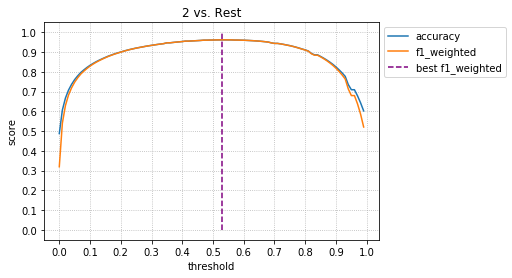

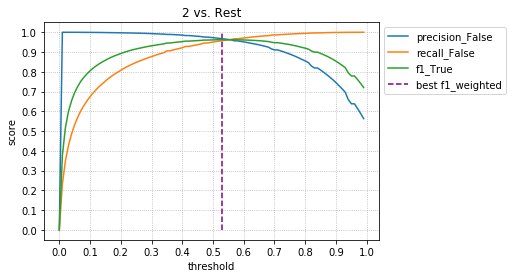

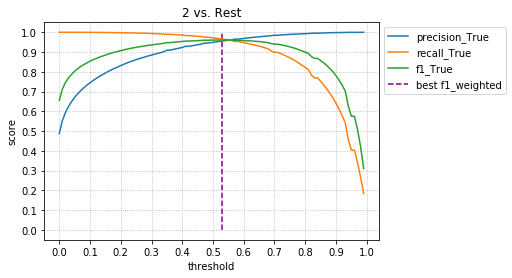

--------------------------------------------------------------------------------
selected_threshold: 0.53
pred_cnt: 71605
true_cnt: 70825 

             precision    recall  f1-score   support  n_predictions

      False      0.967     0.957     0.962     74428          73648
       True      0.956     0.966     0.961     70825          71605

avg / total      0.962     0.962     0.962    145253


accuracy: 0.961501655732


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 2
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
starting OVR fit for value: 6 ...

NOTE: metrics for value=6 reported during training excludes classes
from previous models. The final classification report may have different
precision, recall, and f1 scores due to incorrect classifications from
previous models.


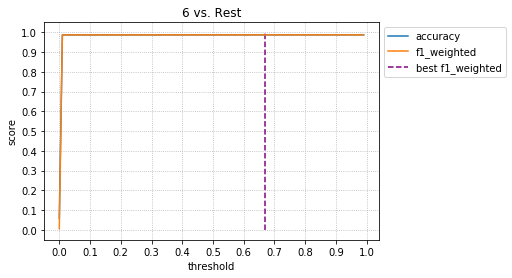

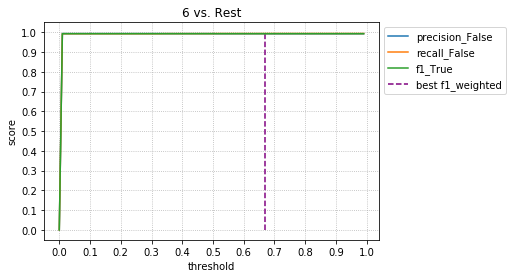

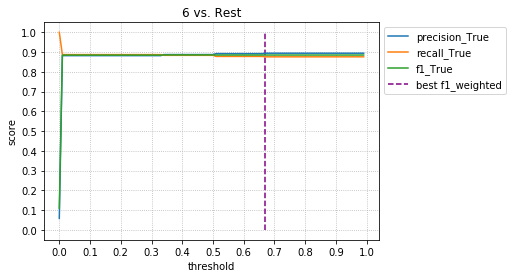

--------------------------------------------------------------------------------
selected_threshold: 0.67
pred_cnt: 4253
true_cnt: 4342 

             precision    recall  f1-score   support  n_predictions

      False      0.992     0.994     0.993     70086          70175
       True      0.894     0.876     0.885      4342           4253

avg / total      0.987     0.987     0.987     74428


accuracy: 0.986685118504


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 6
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
starting OVR fit for value: 5 ...

NOTE: metrics for value=5 reported during training excludes classes
from previous models. The final classification report may have different
precision, recall, and f1 scores due to incorrect classifications from
previous models.


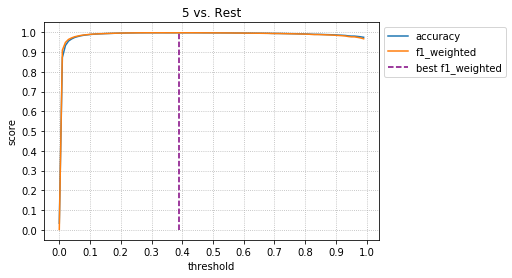

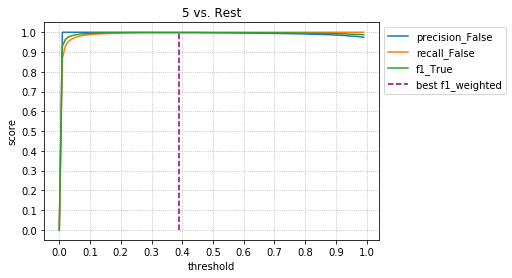

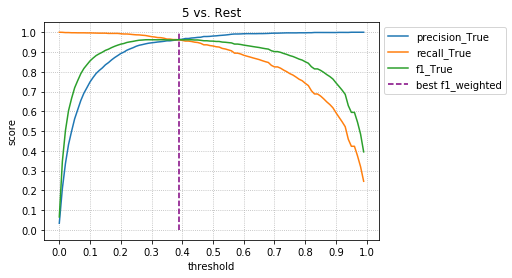

--------------------------------------------------------------------------------
selected_threshold: 0.39
pred_cnt: 2368
true_cnt: 2373 

             precision    recall  f1-score   support  n_predictions

      False      0.999     0.999     0.999     67713          67718
       True      0.963     0.961     0.962      2373           2368

avg / total      0.997     0.997     0.997     70086


accuracy: 0.997445994921


--------------------------------------------------------------------------------
finished Ordered OVR fit for value: 5
--------------------------------------------------------------------------------

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.487395
[20]	valid_0's multi_logloss: 0.235777
[30]	valid_0's multi_logloss: 0.13944
[40]	valid_0's multi_logloss: 0.0967293
[50]	valid_0's multi_logloss: 0.0765711
[60]	valid_0's multi_logloss: 0.0653328
[70]	valid_0's multi_logloss: 0.057889
[80]	valid_0's multi_logloss: 0.0528

OrderedOVRClassifier(model_dict={2: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight....0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)},
           model_fit_params={2: {}, 'final': {'verbose': 10}, 6: {}, 5: {}},
           ovr_vals=[2, 6, 5], target='Cover_Type')

In [5]:
oovr.fit(train_df, eval_set=test_df)

---

### Plot Feature Importance

Now that we have a model trained to classify all the data points, let's evaluate which features are impacting our predictions the most.  

This is an example of how to plot model-agnostic feature importance calculations using OrderedOVRClassifier. Refer to the [API](https://alvinthai.github.io/OrderedOVRClassifier/api_reference.html#plotting-api) for a description of what's going on under the hood.

Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
Multiprocessing failed, going single process


[54/54] features ████████████████████ Time elapsed: 62 seconds

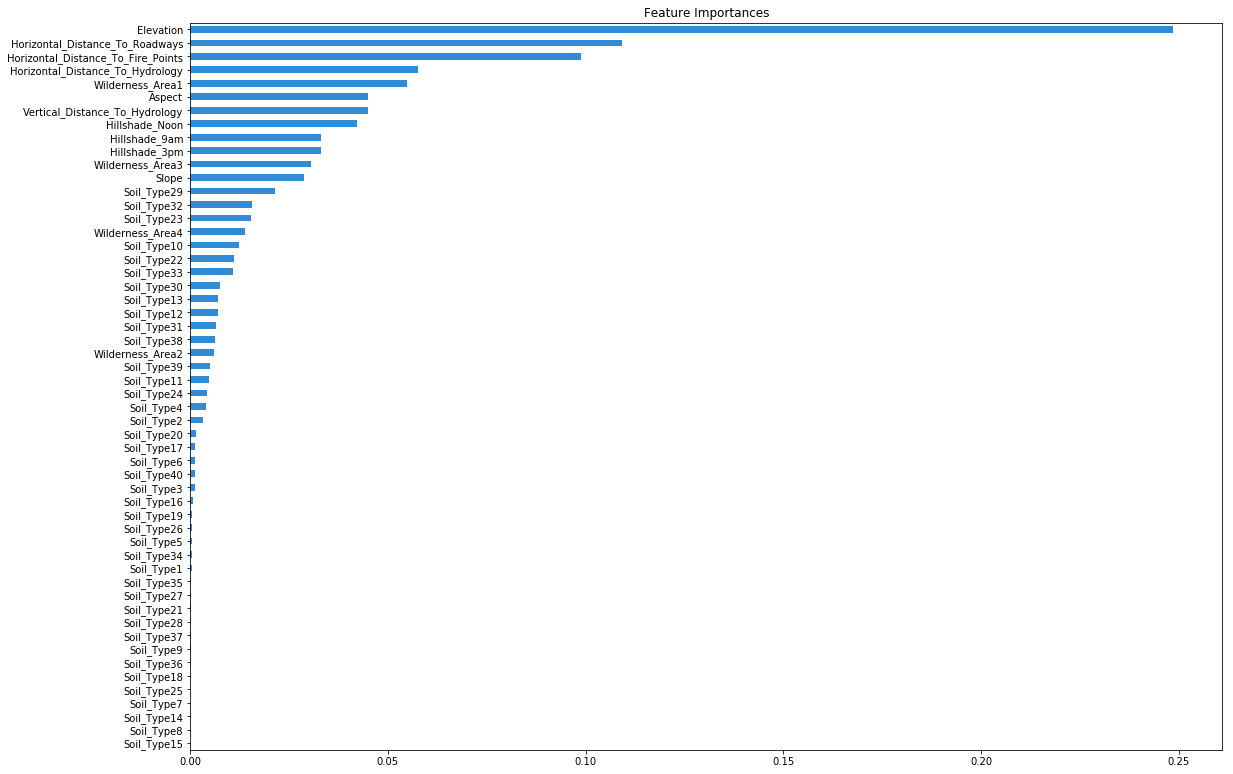

In [6]:
oovr.plot_feature_importance(train_df)

---

### Plot Partial Dependence

`Elevation` is clearly the most important feature among the 54 attributes in the Covertype dataset.  

We may be interested in seeing how the predictions for the multiclassifications varies as `Elevation` changes.  

Below shows an example of how to plot model-agnostic partial dependence calculations (with respect to a single variable) using OrderedOVRClassifier. Refer to the [API](https://alvinthai.github.io/OrderedOVRClassifier/api_reference.html#OrderedOVRClassifier.plot_partial_dependence) for a description of what's going on under the hood.  

Class *1* is the most probable classification for `Elevation > 3000`, Class *2* is the most probable classification for `Elevation > 2400 and Elevation < 3000`, Classes *3* and *6* are more prevalent at lower `Elevation`, and Class *7* is more prevalent at higher `Elevation`.

Progress bars slow down runs by 10-20%. For slightly faster runs, do progressbar=False


[100/100] grid cells ████████████████████ Time elapsed: 19 seconds

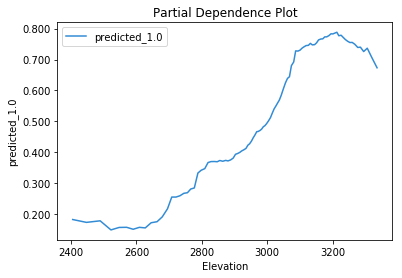

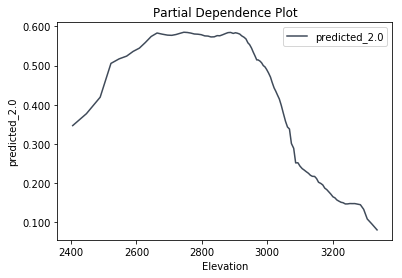

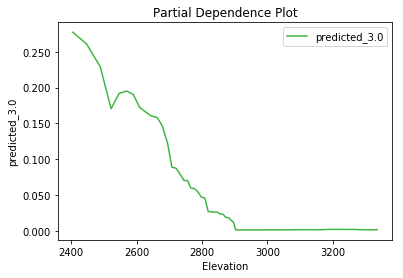

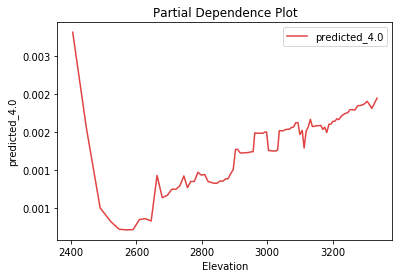

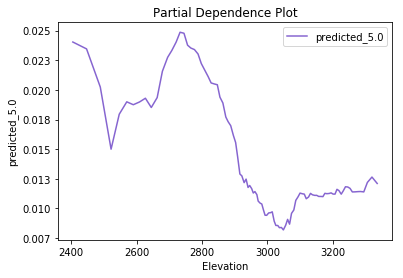

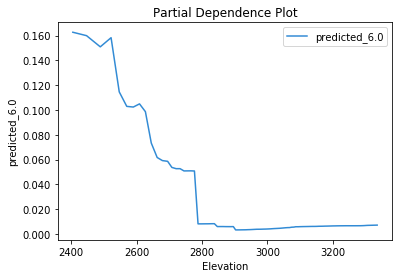

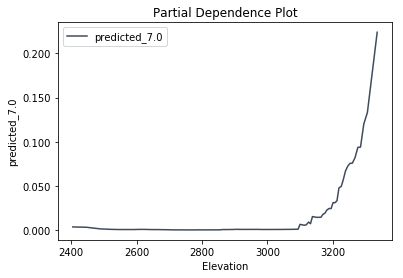

In [7]:
oovr.plot_partial_dependence(train_df, 'Elevation')

---

### Plot Threshold Dependent Metrics

We may be interested in sacrificing accuracy or recall for one class to imporve accuracy or recall in another. With OrderedOVRClassifier, we can adjust our binary classification thresholds to our desired preferences!  

The below diagnostic plots can be generated with the `plot_threshold_dependence` method. If we are hypothetically looking for 98% recall on Class *1* and are willing to take a hit to 90% recall for Class *2*, these plots tell us we should set the binary classifier threshold for class *2* to 0.70 to achieve this goal.

Note that to fit OrderedOVRClassifier with custom thresholds, the model should be refit with a dictionary passed into the **set_threshold** parameter. For example:
```python
oovr.fit(train_df, eval_set=test_df, set_threshold={2: 0.70})
```

Calculating accuracy: 100%|██████████| 100/100 [00:02<00:00, 40.04it/s]


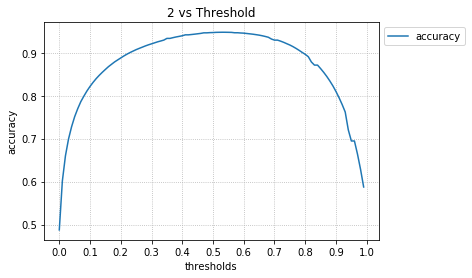

Calculating precision, recall, and f1: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


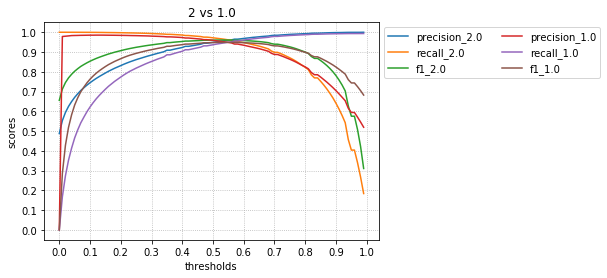

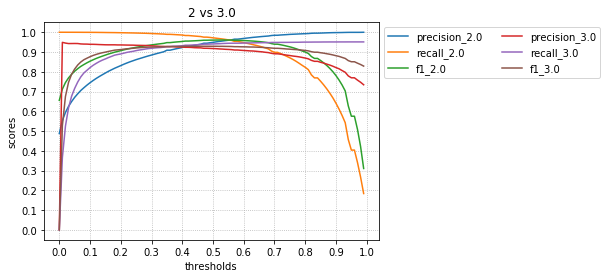

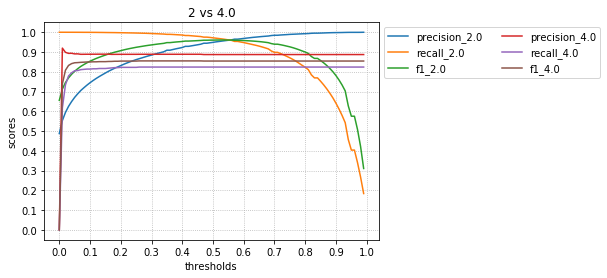

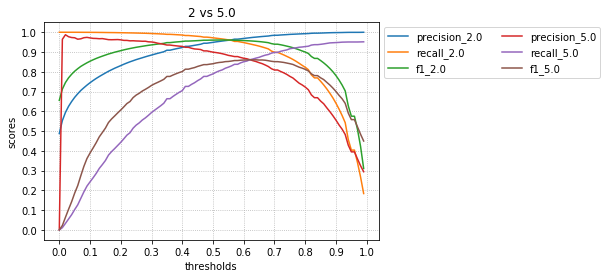

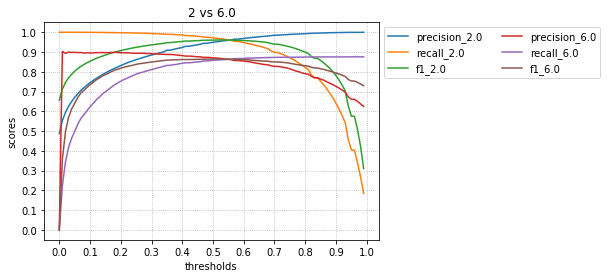

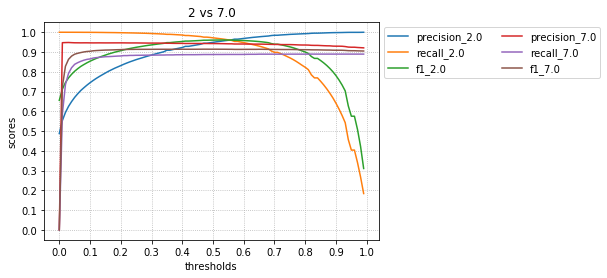

In [8]:
oovr.plot_threshold_dependence(2, test_df)

---

### Test and Attach Models

OrderedOVRClassifier can be fit without training the full model pipeline. Note that a full model pipeline is required for OrderedOVRClassifier to make predictions.  

The below code refits the model with `train_final_model=False`, which skips the training step for the final model.  

In [9]:
%%capture
oovr.fit(train_df, eval_set=test_df, train_final_model=False)

---

**Grid Search**

Let's execute a simple grid search to see if there are better hyper-parameters for tuning the final model of the pipeline.  

The `fit_test_grid` method in OrderedOVRClassifier is designed to handle GridSearchCV and RandomizedSearchCV from the [sklearn.model_selection](http://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) module.  

**Bonus:** The `fit_test_grid` method can also search hyperparameters for GridSearchCV and RandomizedSearchCV models with a [sklearn.pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) estimator. However, the ability to support Pipeline models is currently not implemented with the other OrderedOVRClassifier methods.

In [10]:
est_lgb = LGBMClassifier()

grid = {'num_leaves': [31, 127, 250],
        'min_child_samples': [5, 20, 35],
        'colsample_bytree': [0.8, 1.0],
        'subsample': [0.8, 1.0]}

gridm = GridSearchCV(est_lgb, grid, scoring='neg_log_loss')

---

In [11]:
results = oovr.fit_test_grid(gridm, train_df, eval_set=test_df)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492884
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492652
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.457457
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.456819
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.443837
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.443296
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492888
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.492652
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.457727
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss:

---

**Attach Model**

The best set of hyper-parameters are {'num_leaves': 250, 'min_child_samples': 5, 'colsample_bytree': 1.0, 'subsample': 0.8}. Let's now train the final model with these hyper-parameters using the `fit_test` method of OrderedOVRClassifier.

In [12]:
best_lgb = LGBMClassifier(n_estimators=100, num_leaves=250, min_child_samples=5,
                          colsample_bytree=1.0, subsample=0.8)

final_model = oovr.fit_test(best_lgb, train_df, eval_set=test_df)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.43547
[20]	valid_0's multi_logloss: 0.173615
[30]	valid_0's multi_logloss: 0.0799611
[40]	valid_0's multi_logloss: 0.0433794
[50]	valid_0's multi_logloss: 0.028134
[60]	valid_0's multi_logloss: 0.0215275
[70]	valid_0's multi_logloss: 0.018478
[80]	valid_0's multi_logloss: 0.0171038
[90]	valid_0's multi_logloss: 0.0163904
[100]	valid_0's multi_logloss: 0.0161061

--------------------------------------------------------------------------------
             precision    recall  f1-score   support  n_predictions

        1.0      0.997     0.998     0.998     52960          53018
        3.0      0.991     0.996     0.993      8938           8985
        4.0      0.947     0.882     0.913       687            640
        7.0      0.982     0.971     0.977      5128           5070

avg / total      0.995     0.995     0.995     67713


accuracy: 0.994757284421



---

The **final_model** object that is returned from the `fit_test` method can be attached to the pipeline using the `attach_model` method of OrderedOVRClassifier.

In [13]:
oovr.attach_model(final_model)

OrderedOVRClassifier(model_dict={2: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight....0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)},
           model_fit_params={2: {}, 'final': {'verbose': 10}, 6: {}, 5: {}},
           ovr_vals=[2, 6, 5], target='Cover_Type')

---

We see an overall classification accuracy of 95.2% with the updated final model. This is an improvement over the 94.8% result we got earlier in [Cell 5](#Cell5)!

In [14]:
oovr.multiclassification_report(test_df)

             precision    recall  f1-score   support  n_predictions

        1.0      0.956     0.953     0.954     52960          52794
        2.0      0.960     0.962     0.961     70825          70960
        3.0      0.919     0.944     0.931      8938           9186
        4.0      0.897     0.838     0.867       687            642
        5.0      0.883     0.827     0.854      2373           2224
        6.0      0.868     0.869     0.869      4342           4351
        7.0      0.975     0.969     0.972      5128           5096

avg / total      0.952     0.952     0.952    145253


accuracy: 0.952145566701



---

That's it for this tutorial. Feel free to contact me (alvinthai@gmail.com) with any comments or questions you may have!